<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 7</strong>
</div>
<div style="text-align: center;">
<strong>RB-Galerkin for a varying-coefficient elliptic equaton</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

# 1 Imports and helper functions

In [1]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from scipy.interpolate import BarycentricInterpolator
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import time

def cheb(N):
    """Return the (N+1)x(N+1) Chebyshev differentiation matrix."""
    
    x = np.cos(np.pi * np.arange(0, N + 1)/N)
    c = np.concatenate(([2], np.ones(N - 1), [2])) * (-1) ** np.arange(0, N + 1)
    X = np.tile(x, (N + 1, 1)).T
    dX = X - X.T
    D = np.outer(c, 1/c) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D, axis=1))
    
    return D, x

def compute_exact_elliptic(xx, f, k):
    """Solve -(k u')' = f on [-1,1] with homogeneous Dirichlet conditions with a Chebyshev spectral method."""
    
    # Chebyshev differentiation matrices:
    N = 400
    D, x = cheb(N)
    D2 = D @ D

    # Assemble and solve:
    D2 = D2[1:N, 1:N]
    RHS = f(x[1:N])
    LHS = - np.diag(k(x[1:N])) @ D2 - np.diag((D @ k(x))[1:N]) @ D[1:N, 1:N]
    u = np.linalg.solve(LHS, RHS)
    u = np.concatenate(([0], u, [0]))

    # Interpolate to new grid:
    uu = BarycentricInterpolator(x, u)(xx)
    
    return uu

# 2 RB-Galerkin for a varying-coefficient elliptic equation

We consider the following one-dimensional elliptic equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& -(k(x;\mu)u'(x;\mu))' = f(x), \quad x \in[-1,1], \\
& \phantom{-}u(-1;\mu) = u(1;\mu) = 0.
\end{align}

We will take the following coefficient $k$ and right-hand side $f$,

$$
k(x, \mu) = \cos^2(2\pi\mu x) + 0.1, \qquad f(x) = \cos(2\pi x) (x^2 - 1).
$$

The reference solution is computed from `compute_elliptic_reference`, which uses a Chebyshev spectral method.

**Note: In this problem, he parameter $\mu$ comes from the varying coefficient $k(\cdot;\mu)$.**

We discretize space with

$$
x_j = -1 + jh, \quad h=2/(N_h+1), \quad 0\leq j\leq N_h+1.
$$

We have the following $N_h$ basis functions on $[-1,1]$. The $N_h$ degrees of freedom are the values at the $N_h$ interior grid points.

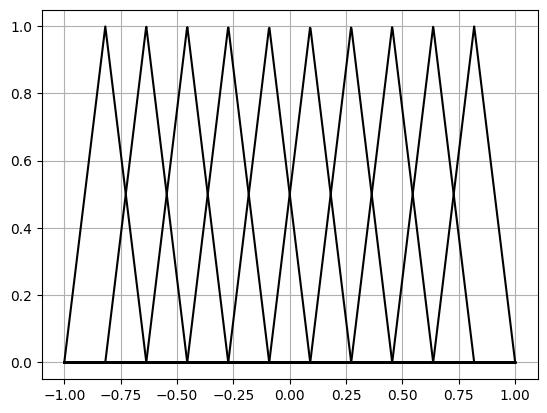

In [2]:
# Computation grid and basis functions:
N_h = 10
h = 2/(N_h + 1)
x_h = np.linspace(-1, 1, N_h + 2)
phi = lambda x: (1 - np.abs(x)) * (np.abs(x) <= 1)
Phi = lambda i, x: phi((x - x_h[i])/h)

# Plot basis functions on a finer grid:
N_eval = 1000
x_eval = np.linspace(-1, 1, N_eval + 1)
plt.figure()
for j in range(1, N_h + 1):
    plt.plot(x_eval, Phi(j, x_eval), 'k')
plt.grid();

## 2.1 Galerkin linear system

We seek a finite element approximation of $u$

$$
u_h(x;\mu) = \sum_{j=1}^{N_h} u_h^j(\mu)\phi_j(x), \qquad u_h^j(\mu) = u_h(x_j;\mu),
$$

which verifies the Galerkin variational problem

$$
\int_{-1}^1 k(x;\mu)u_h'(x;\mu)\phi_i'(x)dx  = \int_{-1}^1 f(x)\phi_i(x)dx, \qquad 1\leq i\leq N_h,
$$

By substituting the expression for $u_h$, we obtain the following linear system,

$$
\sum_{j=1}^{N_h} k(x;\mu) u_h^j(\mu)\int_{-1}^1 \phi_i'(x)\phi_j'(x)dx = \int_{-1}^1 f(x)\phi_i(x)dx, \qquad 1\leq i\leq N_h.
$$ 

We set

$$
(A_h(\mu))_{ij} = \int_{-1}^1 k(x;\mu)\phi_i'(x)\phi_j'(x)dx, \qquad (F_h)_i = \int_{-1}^1 f(x)\phi_i(x)dx, \qquad (M_h)_{ij} = \int_{-1}^1 \phi_i(x)\phi_j(x)dx.
$$

Then the $N_h\times N_h$ Galerkin linear system reads

$$
A_h(\mu) U_h(\mu) = F_h \approx M_h\widetilde{F}_h,
$$

with unknown $U_h(\mu) = (u_h^1(\mu),\ldots,u_h^{N_h}(\mu))^T$ and

$$
M_h = \frac{h}{3}\mathrm{tridiag}(0.5, 2, 0.5), \quad \widetilde{F}_h = \begin{pmatrix} f(x_1) \\ \vdots \\ f(x_{N_h}) \end{pmatrix}.
$$

We further approximate, on each subinterval $[x_i,x_{i+1}]$,

$$
k(x;\mu) \approx k((x_i + x_{i+1})/2;\mu).
$$

We write
$$
\bar{k}_i(\mu) = k((x_i + x_{i+1})/2; \mu), \qquad 0\leq i\leq N_h.
$$

### Exercise (theory)

{exercise}
Show that

$$
A_h(\mu) = \frac{1}{h}\mathrm{tridiag}(d_1(\mu), d_0(\mu), d_1(\mu)),
$$

where

$$
d_0(\mu) = \mathrm{diag}(\bar{k}_{i-1}(\mu) + \bar{k}_i(\mu)), \quad 1\leq i\leq N_h, \qquad d_1(\mu) = \mathrm{diag}(-\bar{k}_i(\mu)), \quad 1\leq i\leq N_h-1.
$$

In other words,

$$
A_h(\mu) = \frac{1}{h}\begin{pmatrix}
\phantom{-}\bar{k}_0 + \bar{k}_1 & -\bar{k}_1 \\
-\bar{k}_1 & \phantom{-}\bar{k}_1 + \bar{k}_2 & -\bar{k}_2 \\
\qquad\quad\ddots & \qquad\quad\ddots & \qquad\quad\ddots \\
& -\bar{k}_{N_{h-2}} & \phantom{-}\bar{k}_{N_{h-2}} + \bar{k}_{N_{h-1}} & -\bar{k}_{N_{h-1}} \\
&& -\bar{k}_{N_{h-1}} & \phantom{-}\bar{k}_{N_{h-1}} + \bar{k}_{N_h}
\end{pmatrix}
$$

# Answer to Exercise 1  
We have already seen (in previous problem sets) that on each $[x_i,x_{i+1}]$ (of length $h$), the derivative of $\phi_i$ is constant :  
- On $[x_{i-1},x_i]$ : $\phi_i'(x)=\frac{1}{h}$  
- On $[x_i,x_{i+1}]$ : $\phi_i'(x)=-\frac{1}{h}$  

### Calculation of the diagonal terms  
By approximating $k(x;\mu)$ by its average value on each subinterval, we have:  

- On $[x_{i-1},x_i]$:  

  $$
  \int_{x_{i-1}}^{x_i} k(x;\mu)\left(\frac{1}{h}\right)^2dx \approx \frac{\bar{k}_{i-1}(\mu)}{h^2}\,h = \frac{\bar{k}_{i-1}(\mu)}{h}
  $$

- On $[x_i,x_{i+1}]$:  

  $$
  \int_{x_i}^{x_{i+1}} k(x;\mu)\left(-\frac{1}{h}\right)^2dx \approx \frac{\bar{k}_i(\mu)}{h^2}\,h = \frac{\bar{k}_i(\mu)}{h}
  $$

By summing these two contributions we obtain:

$$
(A_h(\mu))_{ii} = \frac{\bar{k}_{i-1}(\mu)+\bar{k}_i(\mu)}{h}
$$

### Calculation of the off-diagonal terms  
On the single interval $[x_i,x_{i+1}]$ where $\phi_i$ and $\phi_{i+1}$ overlap, we have:

$$
\phi_i'(x)=-\frac{1}{h}
\quad\text{and}\quad
\phi_{i+1}'(x)=\frac{1}{h}
$$

Hence,

$$
(A_h(\mu))_{i,i+1} = \int_{x_i}^{x_{i+1}} k(x;\mu)\left(-\frac{1}{h}\right)\left(\frac{1}{h}\right)dx \approx -\frac{\bar{k}_i(\mu)}{h}
$$

and by symmetry,

$$
(A_h(\mu))_{i+1,i} = -\frac{\bar{k}_i(\mu)}{h}
$$

### Conclusion  
We have shown that:

- **On the diagonal**: $(A_h(\mu))_{ii} = \frac{\bar{k}_{i-1}(\mu)+\bar{k}_i(\mu)}{h}$  
- **On the sub-diagonal and super-diagonal**: $(A_h(\mu))_{i,i+1} = (A_h(\mu))_{i+1,i} = -\frac{\bar{k}_i(\mu)}{h}$  

The matrix can thus be written as:

$$
A_h(\mu) = \frac{1}{h}\begin{pmatrix}
\phantom{-}\bar{k}_0 + \bar{k}_1 & -\bar{k}_1 \\
-\bar{k}_1 & \phantom{-}\bar{k}_1 + \bar{k}_2 & -\bar{k}_2 \\
\qquad\quad\ddots & \qquad\quad\ddots & \qquad\quad\ddots \\
& -\bar{k}_{N_{h-2}} & \phantom{-}\bar{k}_{N_{h-2}} + \bar{k}_{N_{h-1}} & -\bar{k}_{N_{h-1}} \\
&& -\bar{k}_{N_{h-1}} & \phantom{-}\bar{k}_{N_{h-1}} + \bar{k}_{N_h}
\end{pmatrix}
$$

Hence the result.

### Exercise

{exercise}
Complete the missing parts.

The $L^\infty$-error should be around $10^{-3}$.

In [3]:
def assemble_matrices(N_h, mu):
    """
    Assemble the stiffness matrix A_h and mass matrix M_h for the Galerkin method.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    mu : float
        A parameter for the coefficient varying-coefficient k.

    Returns
    -------
    A_h : scipy.sparse.csc_matrix
        The stiffness matrix of size (N_h, N_h).
    M_h : scipy.sparse.csc_matrix
        The mass matrix of size (N_h, N_h).
    """

    # Grid size and grid:
    h = 2/(N_h + 1)
    x_h = [-1+j*h for j in range(N_h + 2)]
    
    # Stifness matrix:
    k = lambda x: np.cos(2*pi*mu*x)**2 + 0.1
    k_bar = [k((x_h[i] + x_h[i+1])/2) for i in range(N_h+1)]
    d_0 = [k_bar[i-1] + k_bar[i] for i in range(1, N_h+1)]
    d_1 = [-k_bar[i] for i in range(1, N_h)]
    A_h =1/h*diags([d_1, d_0, d_1], offsets=[-1, 0, 1], shape=(N_h, N_h))

    # Mass matrix:
    M_h = h/3*diags([0.5, 2, 0.5], offsets=[-1, 0, 1], shape=(N_h, N_h))
    
    return A_h, M_h

def solve_galerkin(N_h, mu):
    """
    Solve the Galkerin linear system.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    mu : float
        The parameter for the coefficient k.

    Returns
    -------
    np.ndarray
        The solution vector of size (N_h,).
    """

    # Grid:
    x_h = [-1+j*2/(N_h+1) for j in range(N_h+2)]

    # Construct the matrices:
    A_h, M_h = assemble_matrices(N_h, mu)

    f = lambda x: np.cos(2*pi*x)*(x**2 - 1)

    # Solve the linear system:
    U_h = np.linalg.solve(A_h.toarray(), M_h.toarray() @ np.array([f(x) for x in x_h[1:-1]]))
    
    return U_h

### Validation

Time (online): 0.10118s
Error (L-inf): 1.28e-03


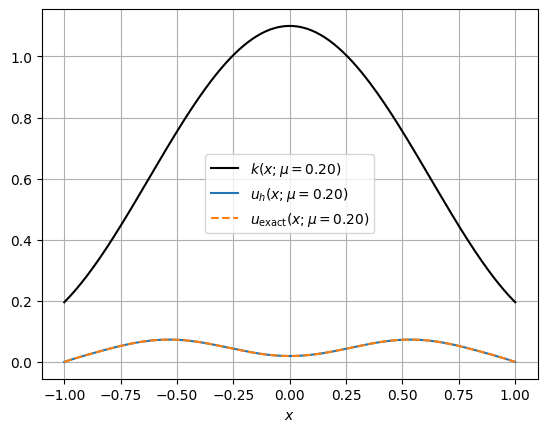

In [4]:
# ODE setup:
mu = 0.2
k = lambda x, mu: np.cos(2*pi*mu*x)**2 + 0.1
f = lambda x: np.cos(2*pi*x)*(x**2 - 1)
u_ex = lambda x, mu: compute_exact_elliptic(x, f, lambda x: k(x, mu))

# Grid setup:
N_h = 100
h = 2/(N_h + 1)
x_h = np.linspace(-1, 1, N_h + 2) # computation grid
N_eval = 200
x_eval = np.linspace(-1, 1, N_eval) # evaluation grid

# Solve Galerkin linear system:
start = time.time() 
U_h = solve_galerkin(N_h, mu)
end = time.time()    
print(f'Time (online): {end-start:.5f}s')

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(1, N_h + 1), x_eval)
u_h = Phi(I, XEVAL) @ U_h

# Compute the L-inf error:
error = np.max(np.abs(u_ex(x_eval, mu) - u_h))/np.max(np.abs(u_ex(x_eval, mu)))
print(f'Error (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval, k(x_eval, mu), '-k', label=r'$k(x; \mu = %.2f)$' % mu)
plt.plot(x_eval, u_h, '-', label=r'$u_h(x; \mu = %.2f)$' % mu)
plt.plot(x_eval, u_ex(x_eval, mu), '--', label=r'$u_\mathrm{exact}(x; \mu = %.2f)$' % mu)
plt.xlabel(r"$x$")
plt.grid()
plt.legend();

## 2.2 Snapshots

Next, we assemble the snapshot matrix

$$
S = [U_h(\mu_1) | \ldots | U_h(\mu_n)] \in \R^{N_h\times n}.
$$

### Exercise

{exercise}
Complete the missing parts.

The $L^\infty$-error should be around $10^{-3}$.

In [5]:
def compute_snapshots(N_h, n, mu):
    """
    Compute a set of solution snapshots using the Galerkin method.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    n : int
        The number of parameter samples.
    mu : np.ndarray
        The vector of parameter values.

    Returns
    -------
    S : np.ndarray
        A matrix of shape (N_h, n) where each column is a solution snapshot.
    """
    
    # Initialize the matrix:
    S = np.zeros((N_h, n)) # replace me

    # Loop over the parameter values:
    for i in range(n):
        S[:, i] = solve_galerkin(N_h, mu[i]) # replace me
        
    return S

### Validation

In [6]:
# Compute snapshots:
n = 50
mu_val = np.linspace(0, 2, n)
start = time.time() 
S = compute_snapshots(N_h, n, mu_val)
end = time.time()
print(f'Time (offline): {end-start:.5f}s')

# Compute exact snapshots:
S_ex = np.zeros((N_h, n))
for i in range(n):
    S_ex[:, i] = u_ex(x_h[1:-1], mu_val[i])

# Compute the L-inf error:
error = np.max(np.abs(S - S_ex))/np.max(np.abs(S_ex))
print(f'Error  (L-inf): {error:.2e}')

Time (offline): 1.38039s
Error  (L-inf): 3.05e-03


## 2.3 Reduced basis

Now, we compute the SVD of $S=U\Sigma V^T$ and set

$$
W = [U_1 | \ldots U_N] \in \R^{N_h\times N},
$$

where $N$ is chosen such that

$$
\frac{\sum_{j=1}^N\sigma_j^2}{\sum_{j=1}^r\sigma_j^2} \geq 1 - \epsilon^2.
$$

### Exercise

{exercise}
Complete the missing parts (same routine as before).

The singular values should decay to $10^{-15}$ and $N$ should be equal to $45$, corresponding to a singular value around $10^{-6}$.

In [8]:
def compute_reduced_basis(S, epsilon):
    """
    Computes a reduced basis using Singular Value Decomposition (SVD) by selecting the
    first N singular vectors that capture a desired amount of energy.

    Parameters
    ----------
    S : numpy.ndarray
        The input matrix for which the reduced basis is to be computed. It should be of shape (N_h, n). 
    epsilon : float
        The energy threshold (0 < epsilon < 1). It determines the fraction of the total energy 
        to be captured by the reduced basis.

    Returns
    -------
    W : numpy.ndarray
        The matrix of the first N singular vectors (reduced basis), with shape (N_h, N), where N is the 
        number of singular vectors selected.
    Sigma : numpy.ndarray
        The vector of singular values of S.
    N : int
        The number of singular vectors selected, corresponding to the desired energy threshold.
    
    Notes
    -----
    The function performs an SVD on the input matrix `S`, computes the cumulative energy captured 
    by the singular values, and selects the minimum number of singular vectors that capture at least 
    (1 - epsilon^2) of the total energy.
    """

    # SVD:
    U, Sigma, VT = np.linalg.svd(S, full_matrices=False) # replace me

    # Choose N from epsilon:
    N = 1
    while (np.sum(Sigma[:N]**2) / np.sum(Sigma**2)) < (1 - epsilon**2):
        N += 1

    # Select the first N singular vectors:
    W = U[:, :N] # replace me

    return W, Sigma, N    

### Validation

45 6.935952696291512e-07 1.4692682848102439e-15


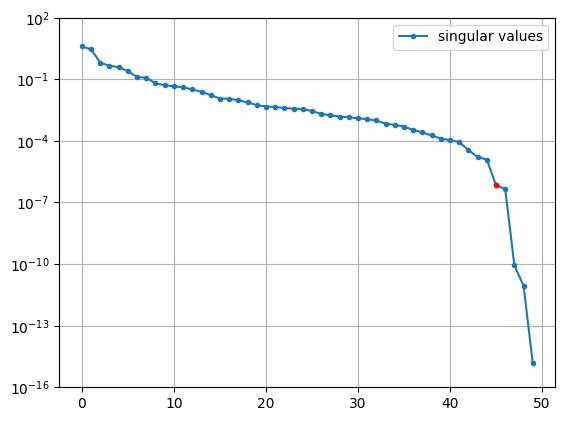

In [9]:
epsilon = 1e-6
W, Sigma, N = compute_reduced_basis(S, epsilon)
print(N, Sigma[N], Sigma[-1])

plt.figure()
plt.semilogy(Sigma, '.-', label="singular values")
plt.semilogy(N, Sigma[N], '.r')
plt.ylim(1e-16, 1e2)
plt.grid()
plt.legend();

## 2.4 Reduced Galerkin system

We finally compute a solution for a new $\mu$ via

$$
A_N(\mu)U_N(\mu) = F_N,
$$

where

$$
A_N(\mu) = W^TA_h(\mu)W, \qquad F_N = W^TF_h \approx W^TM_h\widetilde{F}_h.
$$

### Exercise

{exercise}
Complete the missing parts.

The $L^\infty$-error should be at most around $10^{-2}$.

In [10]:
def solve_reduced_galerkin(W, N_h, mu):
    """
    Solves the reduced Galerkin linear system using the reduced basis.

    Parameters
    ----------
    W : numpy.ndarray
        The matrix of the reduced basis, with shape (N_h, N).
    N_h : int
        The number of interior grid points.
    mu : float
        The parameter for the varying-coefficient k.

    Returns
    -------
    U_N : numpy.ndarray
        The solution of the reduced Galerkin system in the reduced space, with shape (N,).

    Notes
    -----
    The function computes the reduced Galerkin system by projecting the original system onto the
    reduced basis. The matrix `A_N` is the reduced stiffness matrix, and `F_N` is the reduced source term.
    The system is solved for `U_N`, which is the solution in the reduced space.
    """

    # Construct the matrices:
    A_h, M_h = assemble_matrices(N_h, mu)
    f = lambda x: np.cos(2*pi*x)*(x**2 - 1)

    # Construct the reduced system:
    A_N = W.T @ A_h.toarray() @ W
    F_N = W.T @ M_h.toarray() @ np.array([f(x) for x in x_h[1:-1]])

    # Solve the reduced system:
    start = time.time()
    U_N = np.linalg.solve(A_N, F_N)
    end = time.time()
    print(f'Time  (online): {end-start:.5f}s')

    return U_N

### Validation

Time  (online): 0.01700s
Error  (L-inf): 1.23e-02


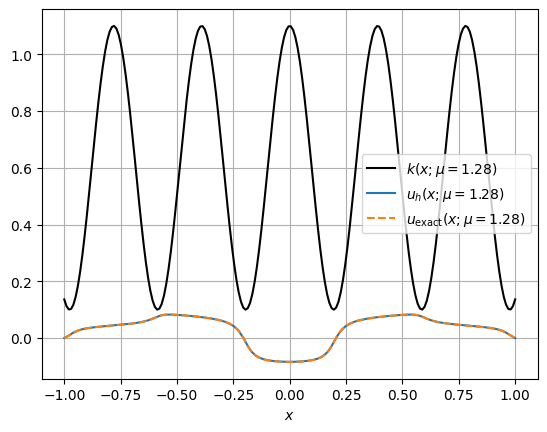

In [11]:
# Compute solution for new mu:
mu_new = mu_val[0] + (mu_val[-1] - mu_val[0]) * np.random.rand()
U_N = solve_reduced_galerkin(W, N_h, mu_new)

# Evaluate solution:
I, XEVAL = np.meshgrid(np.arange(1, N_h + 1), x_eval)
u_h = Phi(I, XEVAL) @ W @ U_N

# Compute the L-inf error:
error = np.max(np.abs(u_ex(x_eval, mu_new) - u_h))/np.max(np.abs(u_ex(x_eval, mu_new)))
print(f'Error  (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval, k(x_eval, mu_new), '-k', label=r'$k(x; \mu = %.2f)$' % mu_new)
plt.plot(x_eval, u_h, '-', label=r'$u_h(x; \mu = %.2f)$' % mu_new)
plt.plot(x_eval, u_ex(x_eval, mu_new), '--', label=r'$u_\mathrm{exact}(x; \mu = %.2f)$' % mu_new)
plt.xlabel(r"$x$")
plt.grid()
plt.legend();